In [219]:
"""Modified Laura's code for internal variability
"""
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
# from tqdm import tqdm
from functools import partial
import json
import tensorflow as tf
from tensorflow.keras import layers
# AUTOTUNE = tf.data.experimental.AUTOTUNE
from dask.diagnostics import ProgressBar
import pathlib


In [220]:

GAN_flag = True
variable = "pr"
input_data_path_base = "/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed"
gcm = "ACCESS-CM2"
ssp = "ssp370"
variant = "r4i1p1f1"
output_path_setup = "/nesi/nobackup/niwa00018/ML_Downscaled_CMIP6/"
emulator_type = "perfect_emulator"
code_dir = "/nesi/project/niwa03712/queenle/ML_emulator"

sys.path.append(f'{code_dir}/code/applying_ml_model/v3')
os.chdir(code_dir)
#try:
from src.util_functions import *
sys.path.append(f'/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/')
from src.layers import *
from src.models import *
from src.gan import *

In [221]:


configs = {"sfcWind": "NIWA-REMS_sfcWind_v050425",
           "sfcWindmax": "NIWA-REMS_sfcWindmax_v050425",
           "tasmax": "NIWA-REMS_tasmax_v050425",
           "tasmin": "NIWA-REMS_tasmin_v050425",
           "pr": "NIWA-REMS_pr_v050425"}
    
method = 'basic' # method of preprocessing input data
'''
Define config file and directories
'''
framework = "imperfect"
# define directories
ground_truth_dir = '/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/'

print('BEGINNING EMULATOR DOWNSCALING')
# Loading up the minimum value dataset
print('Variable: ' + variable + os.getcwd())
ml_model_name = configs[variable]
print(f"current path: {os.getcwd()}, code_dir: {code_dir}")
min_value = None#xr.open_dataset(r'./models/' + ml_model_name + '/min_value_outputs.nc')
print(input_data_path_base, gcm, ssp,
                                    variant, output_path_setup, variable, configs)
input_file, output_path = get_files(input_data_path_base, gcm, ssp,
                                    variant, output_path_setup, variable, configs)

BEGINNING EMULATOR DOWNSCALING
Variable: pr/scale_wlg_persistent/filesets/project/niwa03712/queenle/ML_emulator
current path: /scale_wlg_persistent/filesets/project/niwa03712/queenle/ML_emulator, code_dir: /nesi/project/niwa03712/queenle/ML_emulator
/nesi/project/niwa03712/CMIP6_data/Downscaled_Preprocessed ACCESS-CM2 ssp370 r4i1p1f1 /nesi/nobackup/niwa00018/ML_Downscaled_CMIP6/ pr {'sfcWind': 'NIWA-REMS_sfcWind_v050425', 'sfcWindmax': 'NIWA-REMS_sfcWindmax_v050425', 'tasmax': 'NIWA-REMS_tasmax_v050425', 'tasmin': 'NIWA-REMS_tasmin_v050425', 'pr': 'NIWA-REMS_pr_v050425'}


In [222]:
model_dir ='/nesi/project/niwa00018/ML_downscaling_CCAM/On-the-Extrapolation-of-Generative-Adversarial-Networks-for-downscaling-precipitation-extremes/models/'
model_dir = './models/'
#ml_model_name ='/new_model_v8_04_25_ACCESS-CM2_0.005pr_ACCESS-CM2_0.01pr_ACCESS-CM2/'
generator, unet_model = load_model(ml_model_name, model_dir)

In [167]:



config_file = model_dir + ml_model_name + '/config_info.json'
with open(config_file) as f:
    config = json.load(f)

output_means = xr.open_dataset(config["means_output"])
output_stds = xr.open_dataset(config["stds_output"])
# LOAD ML MODEL
print('LOAD ML MODEL\n')

# PREP INPUT
print('\nPREP INPUT')
processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year = prepare_ML_inputs(input_file, config,
                                                                                               framework, method = method)
# PREP OUTPUT

with ProgressBar():
    mean_data = mean_data.load()
    variance_data = variance_data.load()
    processed_GCM_data = processed_GCM_data.load()
    time_of_year = time_of_year.load()
    print(mean_data, time_of_year)
print('PREP OUTPUT')
output_shape = initialize_output_ds(processed_GCM_data, config)
output_shape = output_shape.rename({"pr": variable})



LOAD ML MODEL


PREP INPUT
[########################################] | 100% Completed | 6.30 ss
	- processing GCM input data
		- unstacking pressure levels
		- normalizing by mean and standard deviation
		- concatenating variables to channel dimension
	- processing mean, variance, and time data


KeyError: 'input_means_means'

In [238]:
GAN_flag = True


In [278]:
"""Modified Laura's code for internal variability
"""
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
# from tqdm import tqdm
from functools import partial
import json
import tensorflow as tf
from tensorflow.keras import layers
# AUTOTUNE = tf.data.experimental.AUTOTUNE
from dask.diagnostics import ProgressBar
import pathlib

'''
add src / ops directory to path, import functions
'''
#sys.path.append('/nesi/project/niwa03712/queenle/ML_emulator/code/applying_ml_model/v3')
''' Due to updates in the ML downscaling repo I have modified this'''
# sys.path.append('/nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan')

# from src.layers import *
# from src.models import *
# from src.gan import *

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow
import xarray as xr
from dask.diagnostics import ProgressBar
from tensorflow.keras.callbacks import Callback
import numpy as np
import pandas as pd

sys.path.append('/nesi/project/niwa00018/ML_downscaling_CCAM/DL_training_160325/multi-task-downscaling')
from src.layers import *
from src.models import *
from src.gan import *
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import Ones, Zeros


def load_model(name, model_path):
    """Modified 05/04/25"""
    generator = tf.keras.models.load_model(f'{model_path}/{name}/generator_final.h5',
                                           custom_objects={"BicubicUpSampling2D": BicubicUpSampling2D,
                                                           "SymmetricPadding2D": SymmetricPadding2D,"FourierLayer":FourierLayer,
                                                           "ComplexLinear":ComplexLinear})
    unet_model = tf.keras.models.load_model(f'{model_path}/{name}/unet_final.h5',
                                            custom_objects={"BicubicUpSampling2D": BicubicUpSampling2D,
                                                            "SymmetricPadding2D": SymmetricPadding2D, "FourierLayer":FourierLayer,
                                                            "ComplexLinear":ComplexLinear})
    return generator, unet_model


def get_files(input_data_path_base, gcm, ssp, variant, output_dir, variable, configs):
    
    if 'ssp' in ssp:
        files = f'{input_data_path_base}/ScenarioMIP/*/{gcm}/{ssp}/{variant}/day/ScenarioMIP_*_{gcm}_{ssp}_{variant}_day_*_v????????.nc'
    else:
        files = f'{input_data_path_base}/CMIP/*/{gcm}/{ssp}/{variant}/day/CMIP_*_{gcm}_{ssp}_{variant}_day_*_v????????.nc'
    files = glob.glob(files, recursive =True)
    filename = files[0].split('/')[-1]
    version = filename.split('_')[-1].strip('.nc')
    grid_label =filename.split('_')[-2]
    new_filename = f"{variable}_{filename.replace(version, configs[variable]).replace(grid_label,'NZ12km')}"
    output_path = f"{output_dir}{files[0].split(input_data_path_base)[1]}".split(filename)[0]
    output_path = f'{output_path}{variable}/NZ_Domain/{version}/{new_filename}'
    return files[0], output_path

@tf.function
def predict_batch_residual_single(model, unet, latent_vectors, data_batch, orog, time_of_year, spatial_means,
                                  spatial_stds, gan=True, varname = "pr"):
    rain = unet([data_batch, orog], training =False)#, time_of_year, spatial_means, spatial_stds], training=False)

    if gan:

        rain_resid = model(
            [latent_vectors[0], latent_vectors[1], data_batch, orog, rain], training=False)#, time_of_year, spatial_means, spatial_stds],
        if varname == "pr":
            rain_resid  = tf.clip_by_value(rain_resid, -10,5
)
                #training=False)
        # multiple residuals
        rain = rain + rain_resid

    return rain
import tensorflow as tf
import math

# Step 1: Create Gaussian kernel
@tf.function
def gaussian_kernel(size: int, sigma: float) -> tf.Tensor:
    """Generates a 2D Gaussian kernel."""
    x = tf.range(-size // 2 + 1, size // 2 + 1, dtype=tf.float32)
    xx, yy = tf.meshgrid(x, x)
    kernel = tf.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= tf.reduce_sum(kernel)
    return tf.reshape(kernel, [size, size, 1, 1])  # shape for tf.nn.conv2d

# Step 2: Compute condition and cast to float32
# condition = tf.logical_and(rain_resid > 3.5, rain < 1.25)
# mask = tf.cast(condition, tf.float32)

# # Ensure input has 4D shape: [batch, height, width, channels]
# mask = tf.expand_dims(mask, axis=0)     # batch
# mask = tf.expand_dims(mask, axis=-1)    # channel

# # Step 3: Apply convolution
# kernel = gaussian_kernel(size=5, sigma=1.0)
# smoothed = tf.nn.conv2d(mask, kernel, strides=1, padding='SAME')



@tf.function
def predict_batch_residual_single_v2(model, unet, latent_vectors, data_batch, orog, time_of_year, spatial_means,
                                  spatial_stds, gan=True, varname = "pr"):
    rain = unet([data_batch, orog], training =False)#, time_of_year, spatial_means, spatial_stds], training=False)
    
    condition = tf.zeros(shape=rain.shape)
    condition = rain > 5.5
    mask = tf.cast(condition, tf.float32)
    # channel
    kernel = gaussian_kernel(size=10, sigma=1.5)
    kernel2 = gaussian_kernel(size=10, sigma=1.5)
    smoothed = tf.nn.conv2d(mask, kernel, strides=1, padding='SAME')
    smoothed_rain = tf.nn.conv2d(rain, kernel2, strides=1, padding='SAME')
    condition = smoothed>0.1


    rain = tf.where(condition, smoothed_rain, rain)
    rain = tf.clip_by_value(rain, -100, 5.5, name=None)
    if gan:

        rain_resid = model(
            [latent_vectors[0], latent_vectors[1], data_batch, orog, rain], training=False)#, time_of_year, spatial_means, spatial_stds],
        # This approach uses the unet prediction, when the deviation is farr too large
        if varname == "pr":
                # Modifying Rain Resid
                condition = tf.logical_or(tf.logical_and(rain_resid > 3.5, rain < 1.25), tf.logical_and(rain_resid > 3, tf.logical_and(rain >= 1.25, rain <= 2.25)))
                mask = tf.cast(condition, tf.float32)
                # channel
                kernel = gaussian_kernel(size=10, sigma=1.5)
                kernel2 = gaussian_kernel(size=10, sigma=1.5)
                smoothed = tf.nn.conv2d(mask, kernel, strides=1, padding='SAME')
                smoothed_resid = tf.nn.conv2d(rain_resid, kernel2, strides=1, padding='SAME')
                condition = smoothed>0.1
                
                
                rain_resid = tf.where(condition, smoothed_resid, rain_resid)
                rain_resid = tf.clip_by_value(rain_resid, -100, 4, name=None)
        rain = rain + rain_resid
    if varname == "pr":
        return rain, condition
    else:

        return rain

def expand_conditional_inputs(X, batch_size):
    expanded_image = tf.expand_dims(X, axis=0)  # Shape: (1, 172, 179)

    # Repeat the image to match the desired batch size
    expanded_image = tf.repeat(expanded_image, repeats=batch_size, axis=0)  # Shape: (batch_size, 172, 179)

    # Create a new axis (1) on the last axis
    expanded_image = tf.expand_dims(expanded_image, axis=-1)
    return expanded_image
def predict_parallel_resid_corrector_v5varname(model, unet, inputs, output_shape, batch_size, orog_vector,
                                               means, stds, time_of_year, spatial_means, spatial_stds, gan=True,
                                               min_value=None, varname='tasmax'):
    """Modified on 06/04/25, predict_batch_residual_single"""
    n_iterations = inputs.shape[0] // batch_size
    remainder = inputs.shape[0] - n_iterations * batch_size

    rainfall = []
    sfcwinds = []
    sfcwindmaxs = []
    tasmaxs = []
    tasmins = []
    conditions =[]

    with tqdm.tqdm(total=n_iterations, desc="Predicting", unit="batch") as pbar:

        for i in range(n_iterations):
            tf.random.set_seed(np.random.randint(0, 10000))
            data_batch = inputs[i * batch_size: (i + 1) * batch_size]
            random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))

            random_latent_vectors2 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[1].shape[1:]))
            # print(random_latent_vectors1.numpy()[0, 1, 1, 1], random_latent_vectors2.numpy()[0, 1, 1, 1])
            orog = expand_conditional_inputs(orog_vector, batch_size)  # ex, he_vector, vegt_vector

#             rain = predict_batch_residual_single(model, unet,
#                                                  [random_latent_vectors1, random_latent_vectors2],
#                                                  data_batch, orog, time_of_year[i * batch_size: (i + 1) * batch_size],
#                                                  spatial_means[i * batch_size: (i + 1) * batch_size],
#                                                  spatial_stds[i * batch_size: (i + 1) * batch_size], gan=gan)
            # In the line below, the time_of_year, spatial_means, and stds are "None" objects
            if varname == "pr":
                rain, condition = predict_batch_residual_single_v2(model, unet,
                                                     [random_latent_vectors1, random_latent_vectors2],
                                                     data_batch, orog, time_of_year,
                                                     spatial_means,
                                                     spatial_stds, gan=gan, varname = varname)
                
                
            else:
                rain = predict_batch_residual_single_v2(model, unet,
                                                     [random_latent_vectors1, random_latent_vectors2],
                                                     data_batch, orog, time_of_year,
                                                     spatial_means,
                                                     spatial_stds, gan=gan, varname = varname)

            if varname == "sfcWind":
                rainfall += ((rain.numpy()[:, :, :, 0]) * stds['sfcWind'].mean().values +
                             means['sfcWind'].mean().values).tolist()
            elif varname == 'sfcWindmax':
                rainfall += ((rain.numpy()[:, :, :, 0]) * stds[
                    'sfcWind'].mean().values + means['sfcWind'].mean().values).tolist()
            elif varname == "pr":
                rainfall_instant = np.exp(rain.numpy()[:, :, :, 0]) - 1
                rainfall_instant = np.clip(rainfall_instant, a_min=0, a_max=1500)
                rainfall += (rainfall_instant).tolist()
                conditions+= (tf.cast(condition,'int32').numpy()[:,:,:,0]).tolist()
            else:
                rainfall += ((rain.numpy()[:, :, :, 0]) * stds[varname].mean().values +
                             means[varname].mean().values).tolist()

            pbar.update(1)

    if remainder != 0:
        tf.random.set_seed(np.random.randint(0, 10000))
        random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))
        random_latent_vectors2 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[1].shape[1:]))
        # random_latent_vectors2 = tf.repeat(random_latent_vectors2, repeats=batch_size, axis=0)
        orog = expand_conditional_inputs(orog_vector, remainder)
#         rain = predict_batch_residual_single(model, unet, [
#             random_latent_vectors1[:remainder], random_latent_vectors2[:remainder]],
#                                              inputs[
#                                              inputs.shape[0] - remainder:],
#                                              orog, time_of_year[inputs.shape[0] - remainder:],
#                                              spatial_means[inputs.shape[0] - remainder:],
#                                              spatial_stds[inputs.shape[0] - remainder:], gan=gan)
        # The below are "None" objects
        if varname == "pr":
            rain, condition = predict_batch_residual_single_v2(model, unet, [
                random_latent_vectors1[:remainder], random_latent_vectors2[:remainder]],
                                                 inputs[
                                                 inputs.shape[0] - remainder:],
                                                 orog, time_of_year,
                                                 spatial_means,
                                                 spatial_stds, gan=gan, varname = varname)
            

        else:
            
            rain = predict_batch_residual_single_v2(model, unet, [
                random_latent_vectors1[:remainder], random_latent_vectors2[:remainder]],
                                                 inputs[
                                                 inputs.shape[0] - remainder:],
                                                 orog, time_of_year,
                                                 spatial_means,
                                                 spatial_stds, gan=gan, varname = varname)

        if varname == "sfcWind":
            rainfall += ((rain.numpy()[:, :, :, 0]) * stds['sfcWind'].mean().values +
                         means['sfcWind'].mean().values).tolist()
        elif varname == 'sfcWindmax':
            rainfall += ((rain.numpy()[:, :, :, 0]) * stds['sfcWind'].mean().values +
                         means['sfcWind'].mean().values).tolist()
        elif varname == "pr":
            rainfall_instant = np.exp(rain.numpy()[:, :, :, 0]) - 1
            rainfall_instant = np.clip(rainfall_instant, a_min=0, a_max=1500)
            rainfall += (rainfall_instant).tolist()
            conditions+= (tf.cast(condition,'int32').numpy()[:,:,:,0]).tolist()
        else:
            rainfall += ((rain.numpy()[:, :, :, 0]) * stds[varname].mean().values + means[
                varname].mean().values).tolist()
    if varname == "pr":
        output_shape["pr_GAN_mask"] = (('time', 'lat', 'lon'), conditions)
        output_shape[varname] = (('time', 'lat', 'lon'), rainfall)
    else:
        
        output_shape[varname] = (('time', 'lat', 'lon'), rainfall)

    return output_shape


def predict_parallel_resid_corrector_v4varname(model, unet, inputs, output_shape, batch_size, orog_vector,
                                               means, stds, time_of_year, spatial_means, spatial_stds, gan=True,
                                               min_value=None, varname='tasmax'):
    """Modified on 06/04/25, predict_batch_residual_single"""
    n_iterations = inputs.shape[0] // batch_size
    remainder = inputs.shape[0] - n_iterations * batch_size

    rainfall = []
    sfcwinds = []
    sfcwindmaxs = []
    tasmaxs = []
    tasmins = []

    with tqdm.tqdm(total=n_iterations, desc="Predicting", unit="batch") as pbar:

        for i in range(n_iterations):
            tf.random.set_seed(np.random.randint(0, 10000))
            data_batch = inputs[i * batch_size: (i + 1) * batch_size]
            random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))

            random_latent_vectors2 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[1].shape[1:]))
            # print(random_latent_vectors1.numpy()[0, 1, 1, 1], random_latent_vectors2.numpy()[0, 1, 1, 1])
            orog = expand_conditional_inputs(orog_vector, batch_size)  # ex, he_vector, vegt_vector

#             rain = predict_batch_residual_single(model, unet,
#                                                  [random_latent_vectors1, random_latent_vectors2],
#                                                  data_batch, orog, time_of_year[i * batch_size: (i + 1) * batch_size],
#                                                  spatial_means[i * batch_size: (i + 1) * batch_size],
#                                                  spatial_stds[i * batch_size: (i + 1) * batch_size], gan=gan)
            # In the line below, the time_of_year, spatial_means, and stds are "None" objects
            rain = predict_batch_residual_single(model, unet,
                                                 [random_latent_vectors1, random_latent_vectors2],
                                                 data_batch, orog, time_of_year,
                                                 spatial_means,
                                                 spatial_stds, gan=gan, varname = varname)

            if varname == "sfcWind":
                rainfall += ((rain.numpy()[:, :, :, 0]) * stds['sfcWind'].mean().values +
                             means['sfcWind'].mean().values).tolist()
            elif varname == 'sfcWindmax':
                rainfall += ((rain.numpy()[:, :, :, 0]) * stds[
                    'sfcWind'].mean().values + means['sfcWind'].mean().values).tolist()
            elif varname == "pr":
                rainfall_instant = np.exp(rain.numpy()[:, :, :, 0]) - 1
                rainfall_instant = np.clip(rainfall_instant, a_min=0, a_max=1500)
                rainfall += (rainfall_instant).tolist()
            else:
                rainfall += ((rain.numpy()[:, :, :, 0]) * stds[varname].mean().values +
                             means[varname].mean().values).tolist()

            pbar.update(1)

    if remainder != 0:
        tf.random.set_seed(np.random.randint(0, 10000))
        random_latent_vectors1 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[0].shape[1:]))
        random_latent_vectors2 = tf.random.normal(shape=(batch_size,) + tuple(model.inputs[1].shape[1:]))
        # random_latent_vectors2 = tf.repeat(random_latent_vectors2, repeats=batch_size, axis=0)
        orog = expand_conditional_inputs(orog_vector, remainder)
#         rain = predict_batch_residual_single(model, unet, [
#             random_latent_vectors1[:remainder], random_latent_vectors2[:remainder]],
#                                              inputs[
#                                              inputs.shape[0] - remainder:],
#                                              orog, time_of_year[inputs.shape[0] - remainder:],
#                                              spatial_means[inputs.shape[0] - remainder:],
#                                              spatial_stds[inputs.shape[0] - remainder:], gan=gan)
        # The below are "None" objects
        rain = predict_batch_residual_single(model, unet, [
            random_latent_vectors1[:remainder], random_latent_vectors2[:remainder]],
                                             inputs[
                                             inputs.shape[0] - remainder:],
                                             orog, time_of_year,
                                             spatial_means,
                                             spatial_stds, gan=gan, varname = varname)

        if varname == "sfcWind":
            rainfall += ((rain.numpy()[:, :, :, 0]) * stds['sfcWind'].mean().values +
                         means['sfcWind'].mean().values).tolist()
        elif varname == 'sfcWindmax':
            rainfall += ((rain.numpy()[:, :, :, 0]) * stds['sfcWind'].mean().values +
                         means['sfcWind'].mean().values).tolist()
        elif varname == "pr":
            rainfall_instant = np.exp(rain.numpy()[:, :, :, 0]) - 1
            rainfall_instant = np.clip(rainfall_instant, a_min=0, a_max=1500)
            rainfall += (rainfall_instant).tolist()
        else:
            rainfall += ((rain.numpy()[:, :, :, 0]) * stds[varname].mean().values + means[
                varname].mean().values).tolist()

    output_shape[varname] = (('time', 'lat', 'lon'), rainfall)

    return output_shape


'''
MY FUNCTIONS FOR PREPROCESSING INPUTS
'''


def prepare_ML_inputs(GCM_input_path, config, framework, spectral_filtering = False, method ='normal_means'):
    """Modified on 06/04/25"""
    with ProgressBar():
        ds = xr.open_mfdataset(GCM_input_path).load()

        print('\t- processing GCM input data')
        processed_GCM_data, means, stds = reformat_GCM_data(ds, config, framework, spectral_filtering = spectral_filtering, method = method)
        processed_GCM_data = processed_GCM_data.load()
        means = means.load()
        stds = stds.load()
        print('\t- processing mean, variance, and time data')
        mean_data, variance_data, time_of_year = process_mean_variance_time(ds, config, framework, means, stds)
        mean_data = mean_data.load()
        variance_data = variance_data.load()
        time_of_year = time_of_year.load()
        print('\t- processing static fields')
        vegt, orog, he = prepare_static_fields(config)
        vegt = vegt.load()
        orog = orog.load()
        he = he.load()
        print('\t- calculating time of year array')

    return (processed_GCM_data, mean_data, variance_data, vegt, orog, he, time_of_year)


def reformat_GCM_data(ds, config, framework, spectral_filtering = False, method ='doury'):
    if framework == 'imperfect':
        # Step 1: unstack pressure levels, change variable names
        print('\t\t- unstacking pressure levels')
        ds = unstack_pressure_levels(ds)

    # Step 2: normalize dataset by mean and st. dev.
    print('\t\t- normalizing by mean and standard deviation')
    ds, means, stds = normalize(ds, config, spectral_filtering = spectral_filtering, spectral_threshold=0.48, method =method)

    # Step 3: concatenate variable dimension
    print('\t\t- concatenating variables to channel dimension')
    da = concatenate_variable_dimension(ds, config)

    return da, means, stds


def unstack_pressure_levels(ds):
    unstacked_ds = ds.copy()

    var_name_dict = {'hus': 'q', 'ta': 't', 'ua': 'u', 'va': 'v'}

    for var in ['hus', 'ta', 'ua', 'va']:
        for lev in unstacked_ds.plev.values:
            if lev > 1e4:
                data = unstacked_ds[var].sel(plev=lev)
                lev = int(lev / 100)
            else:
                data = unstacked_ds[var].sel(plev=lev)

            unstacked_ds[f'{var_name_dict[var]}_{int(lev)}'] = data

        unstacked_ds = unstacked_ds.drop([var])

    return (unstacked_ds)


def normalize(ds, config, spectral_filtering = False, spectral_threshold=0.48, method ='normal_means'):
    var_list = config['var_names']
    
    if spectral_filtering:
        print('\t\t\t- Spectral filtering of the input variables')
        ds_new = ds[var_list].copy() * np.nan
        for varname in var_list:
            ds_new[varname].data = low_pass_filter(ds[varname].transpose("time","lat","lon").values, cutoff = spectral_threshold)
            print(f"Spectrally modified variable: {varname}")
        ds = ds_new 
    if method == 'doury':    
        means = ds[var_list].mean(['lat', 'lon'])
        stds = ds[var_list].std(['lat', 'lon'])
        norm_ds = (ds[var_list] - means) / stds
    else:
        means_NORM = xr.open_dataset(config["mean"])
        stds_NORM = xr.open_dataset(config["std"])
        norm_ds = (ds[var_list] - means_NORM.mean(["lat","lon"])) / stds_NORM.mean(["lat","lon"])
        means = ds[var_list].mean(['lat', 'lon'])
        stds = ds[var_list].std(['lat', 'lon'])

    return norm_ds, means, stds



def concatenate_variable_dimension(ds, config):
    var_list = config['var_names']

    # concatenate dataarrays of each variables along dimension 'channel'
    concatenated_da = xr.concat([ds[var] for var in var_list], dim="channel")
    concatenated_da = concatenated_da.rename('GCM_da')

    # name channel dimension values by variables names
    concatenated_da['channel'] = (('channel'), var_list)

    return (concatenated_da)


def process_mean_variance_time(ds, config, framework, GCM_spatial_means, GCM_spatial_stds):
    var_list = config['var_names']

    if framework == 'imperfect':
        ds = unstack_pressure_levels(ds)

    ds = ds[var_list]

    # single values
    predictor_means_mean = xr.open_dataset(config["input_means_means"])
    predictor_means_variance = xr.open_dataset(config["input_means_stds"])

    predictor_stds_mean = xr.open_dataset(config["input_stds_means"])
    predictor_stds_variance = xr.open_dataset(config["input_stds_stds"])

    # time series
    # = ds.mean(['lat', 'lon'])
    #GCM_spatial_stds = ds.std(['lat', 'lon'])

    # stack normalized means
    norm_spatial_means = (GCM_spatial_means - predictor_means_mean) / predictor_means_variance
    norm_spatial_means = xr.concat([norm_spatial_means[i] for i in var_list], dim="channel")
    norm_spatial_means['channel'] = (('channel'), var_list)

    # stack normalized st. deviations
    norm_spatial_stds = (GCM_spatial_stds - predictor_stds_mean) / predictor_stds_variance
    norm_spatial_stds = xr.concat([norm_spatial_stds[i] for i in var_list], dim="channel")
    norm_spatial_stds['channel'] = (('channel'), var_list)

    time_of_year = np.sin(2 * np.pi * norm_spatial_means.time.dt.dayofyear / 365)

    return (norm_spatial_means, norm_spatial_stds, time_of_year)


def prepare_static_fields(config):
    topography_data = xr.open_dataset(config["static_predictors"])

    vegt = topography_data.vegt
    orog = topography_data.orog
    he = topography_data.he

    # normalize to the range [0,1]
    vegt = (vegt - vegt.min()) / (vegt.max() - vegt.min())
    orog = (orog - orog.min()) / (orog.max() - orog.min())
    he = (he - he.min()) / (he.max() - he.min())

    return (vegt, orog, he)


def initialize_output_ds(input_ds, config):
    print('\t- initializing output data structure')

    example_output = xr.open_dataset(config['train_y'])

    try:
        example_output = example_output.isel(GCM=0)[['pr']]
    except:
        example_output = example_output[['pr']]

    output_shape = example_output.isel(time=0).drop(['time'])
    output_shape = output_shape.expand_dims({"time": input_ds.time.size})
    output_shape['time'] = (('time'), input_ds.time.to_index())

    output_shape.pr.values = output_shape.pr.values * 0

    return (output_shape)


def determine_file_count(frameworks, variables, GCMs, scens):
    count = 0
    if 'imperfect' in frameworks:
        count += len(variables) * len(GCMs) * len(scens)

    if 'perfect' in frameworks:
        if 'historical' in scens:
            count += len(variables) * len(GCMs) * (
                        len(scens) - 1)  # don't count historical scens, will be skipped because coarsened RCM files have hist+ssp combined
        else:
            count += len(variables) * len(GCMs) * len(scens)

    return str(count)




In [329]:
np.exp(2+3.25)

190.56626845863

In [267]:
# processed_GCM_data.transpose('time', 'lat', 'lon',     'channel').sel(time=slice(2090, 2091))
                             

In [330]:
    # APPLY MODEL
ts = slice("2093","2093")
print('APPLY ML MODEL')
output = predict_parallel_resid_corrector_v5varname(generator, unet_model,
                                                    processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                 'channel').sel(time = ts).values, \
                                                    output_shape.sel(time = ts), 64, orog, output_means, output_stds, time_of_year.sel(time = ts), \
                                                    mean_data.transpose('time', 'channel').sel(time = ts),
                                                    variance_data.transpose('time', 'channel').sel(time = ts), gan=GAN_flag, \
                                                    min_value=min_value, varname=variable)




APPLY ML MODEL


Predicting: 100%|██████████| 5/5 [00:05<00:00,  1.08s/batch]


In [338]:
output.pr_GAN_mask.sum(["lat","lon"]).where(output.pr_GAN_mask.sum(["lat","lon"])>0, np.nan).dropna("time")


<xarray.DataArray 'pr_GAN_mask' (time: 24)>
array([ 36.,   6.,  15.,  10.,  36.,  12.,   9., 123.,  15.,  16.,   9.,
        24.,   6.,  13.,  41.,  14.,   4.,  28.,  16.,  69.,  52.,   9.,
        23.,  30.])
Coordinates:
    GCM      <U10 'ACCESS-CM2'
  * time     (time) datetime64[ns] 2093-01-19T12:00:00 ... 2093-12-24T12:00:00

In [204]:
df_test = xr.open_dataset(config["train_y"])

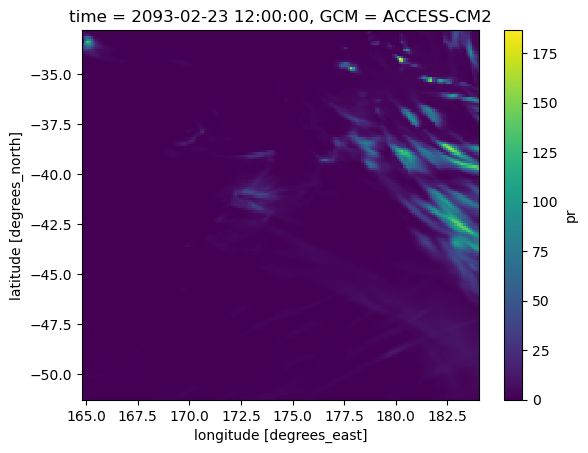

In [344]:
(df_test.isel(GCM =0).sel(time = "2093-02-23").pr*86400).plot()

In [317]:
output.sel(time = "2076-01-13").pr.plot()

KeyError: '2076-01-13'

In [327]:
output.sel(time = "2076-01-13").pr_GAN_mask.plot()

KeyError: '2076-01-13'

In [269]:
output.sel(time = "2093-02-21").pr.plot(vmax =150)

KeyError: '2076-01-13'

In [333]:
output.sel(time = "2093-00-20").pr.plot()

KeyError: '2093-00-20'

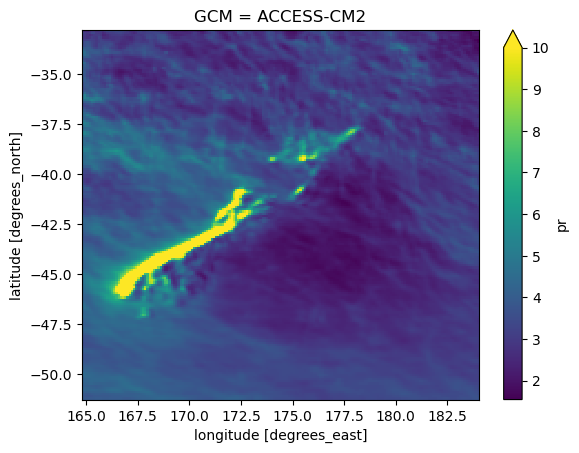

In [325]:
(df_test.isel(GCM =0).sel(time = slice("2093","2093")).pr*86400).mean("time").plot(vmax =10)

In [313]:
np.exp(7
      )

1096.6331584284585

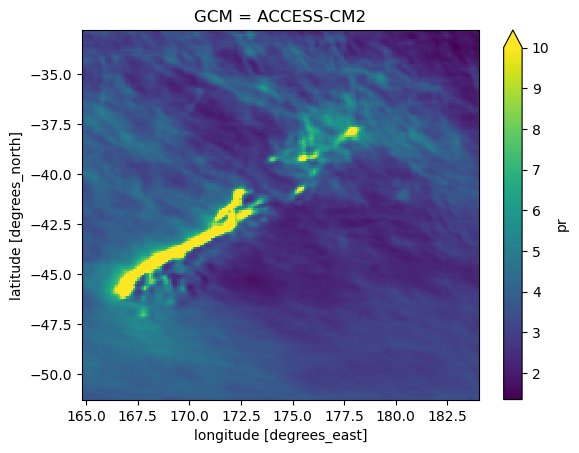

In [324]:
output.mean("time").pr.plot(vmax =10)

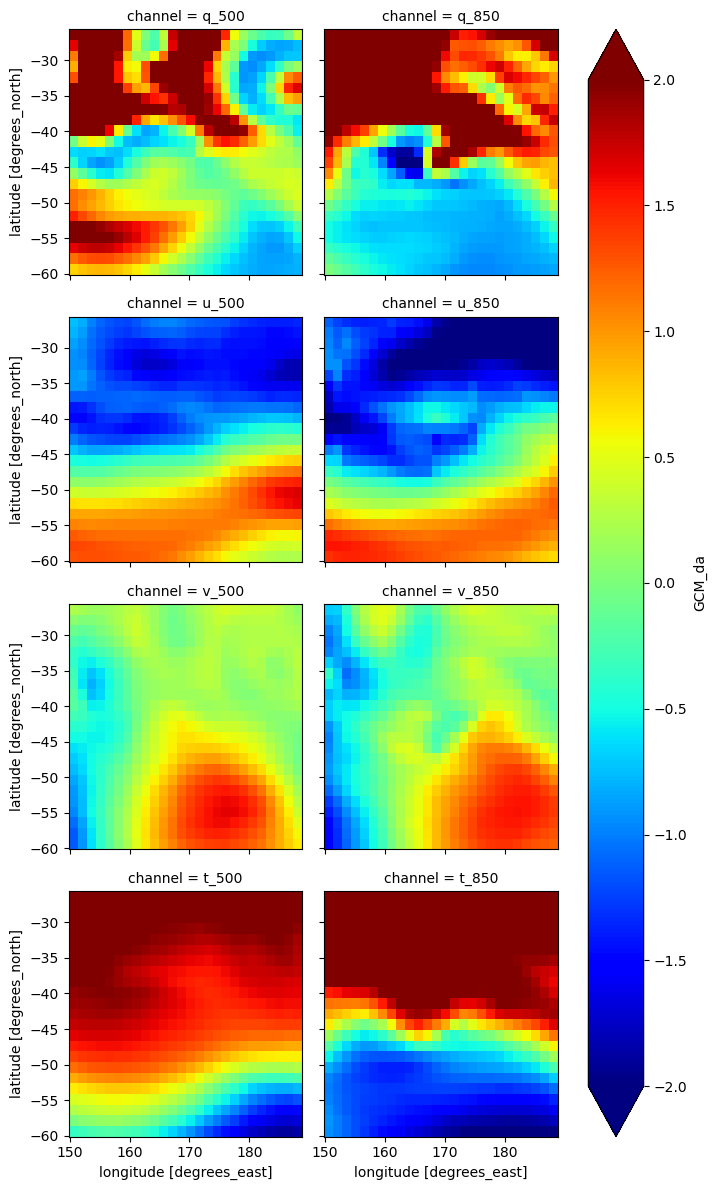

In [202]:
processed_GCM_data.transpose('time', 'lat', 'lon',
                                                                                 'channel').sel(time = "2076-01-13").squeeze().plot(col ="channel",col_wrap =2, vmax =2, vmin =-2, cmap ='jet')

In [350]:
np.exp(5+3)

2980.9579870417283

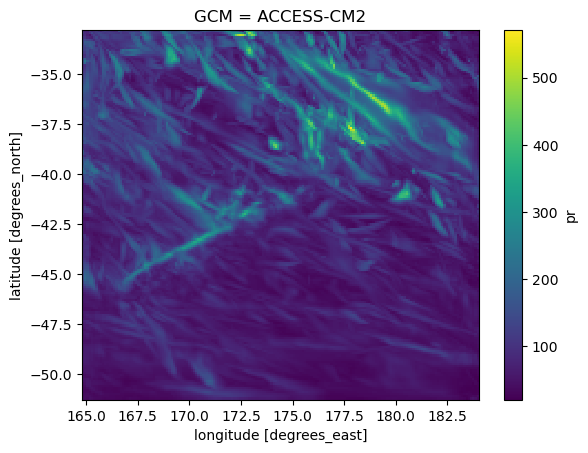

In [326]:
output.max("time").pr.plot()

In [198]:
df = xr.open_dataset(r'//nesi/nobackup/niwa03712/ML_Downscaled_CMIP6/NIWA-REMS_CCAM_public/ssp370/daily/pr/pr_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp370_r4i1p1f1_day_NZ12km_NIWA-REMS_pr_v280125.nc')

In [ ]:
output.sel(time = "2093-02-22").pr.plot()

In [1]:
import xarray as xr


In [ ]:
df = xr.open_dataset

In [116]:
output.pr_GAN_mask.sum(["lat","lon"]).where(output.pr_GAN_mask.sum(["lat","lon"]), np.nan).dropna("time")

<xarray.DataArray 'pr_GAN_mask' (time: 100)>
array([ 28.,  33.,  19.,  27.,   6.,  60.,  25.,   8.,  16.,   6.,  32.,
        67., 106., 110.,  79.,  95.,  97.,  77., 114., 136.,  90.,  14.,
        65.,  80.,  76.,  36.,   6.,  70.,  69.,  86.,  96.,   9.,  49.,
        18.,  16.,  10.,  10.,  71., 100.,  49.,  12.,  30.,  68.,   4.,
        30.,  30.,  14., 119.,   6.,   9.,  12.,   8.,   4.,  25.,   4.,
         4.,  30.,  12.,  26.,  18.,   6.,  22.,   6.,  10.,   6.,   6.,
         4., 103.,  42.,  16.,  37.,  92.,   4.,  16.,  40., 167.,  57.,
       110.,  34.,  66.,  23.,  53.,   4.,  43.,   4.,  69.,  40.,  10.,
        34.,  10.,  31.,   6.,  99.,  44.,  34.,  58.,  41.,  33.,   9.,
        27.])
Coordinates:
    GCM      <U10 'ACCESS-CM2'
  * time     (time) datetime64[ns] 2098-01-17T12:00:00 ... 2099-12-31T12:00:00

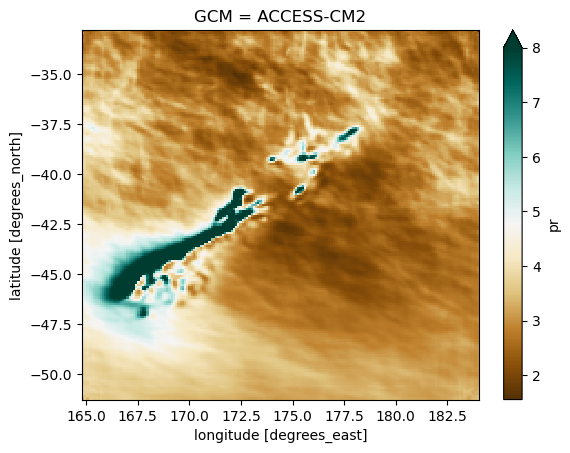

In [124]:
output.pr.mean("time").plot(vmax =8, cmap ='BrBG')

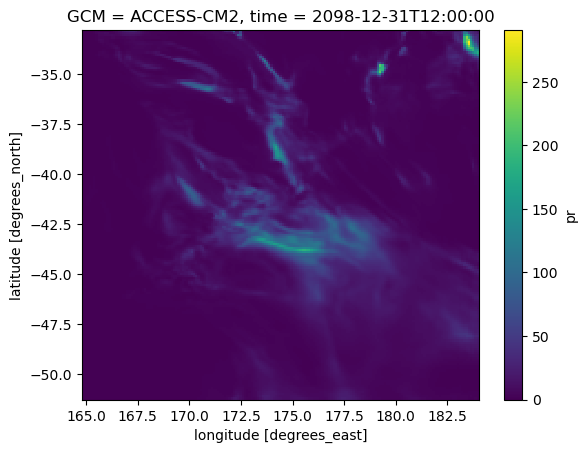

In [125]:
output.sel(time = "2098-12-31").pr.plot()

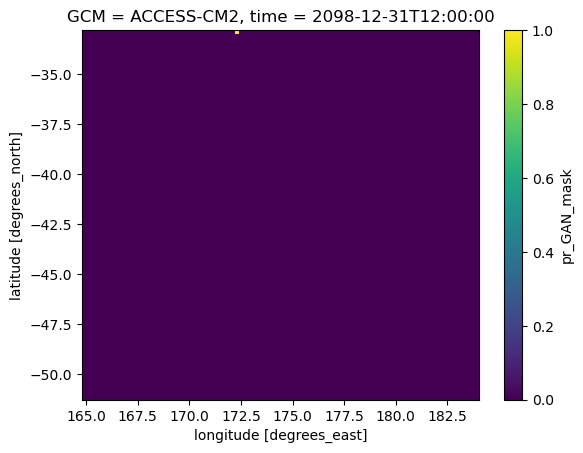

In [126]:
output.sel(time = "2098-12-31").pr_GAN_mask.plot()

In [ ]:
#output.coords['GCM'] = f'{gcm}'
#output.coords['scenario'] = f'{ssp}'
#o#utput.coords['GCM'].attrs["info"] = f'The gcm that was downscaled'
#output.coords['scenario'].attrs["info"] = f'The ssp that was downscaled'
output.attrs['title'] = 'Generative AI Downscaled data'
output.attrs['contact'] = 'Neelesh Rampal (neelesh.rampal@niwa.co.nz)'
output.attrs['CMIP6_model'] = f'{gcm}'
output.attrs['CMIP6_scenario'] = f'{ssp}'
output.attrs['version'] = f"{configs[variable]} of CCAM Version: {output.attrs['version']}"
output.attrs[
    'source'] = f"NIWA-REMS Generative AI Downscaling: https://github.com/nram812/On-the-Extrapolation-of-Generative-Adversarial-Networks-for-downscaling-precipitation-extremes \n Training Data is from {output.attrs['source']}"
output.attrs['training_data'] = 'https://zenodo.org/records/13755688'
parent_path = pathlib.Path(output_path).parents[0]

In [ ]:

if not os.path.exists(parent_path):
    os.makedirs(parent_path)

output.to_netcdf(output_path)
print('\n\n')